- DBSCAN、HDBSCAN等方法將資料分群
- 觀察分群參數及結果
- 進一步的資料標記

In [137]:
import gc
import os
import sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import shutil
import joblib
from sklearn.metrics import euclidean_distances
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import hdbscan
from sortedcontainers import SortedDict

from upsetplot import UpSet, from_indicators

from utils.DefaultValue import *
import copy

pd.set_option('display.max_columns', None)

## Load Data

### Load from Pickle Object

In [138]:
month_list = [
  ('01', '31'),
  ('02', '28'),
  ('03', '31'),
  ('04', '30'),
  ('05', '31'),
  ('06', '30'),
  ('07', '31'),
  ('08', '31'),
  ('09', '30'),
  ('10', '31'),
  ('11', '30'),
  ('12', '31')
]
#set date
start_date = "20230401"
end_date = "20230609"

# count month included
start_month = int(start_date[4:6])
end_month = int(end_date[4:6])
month_cnt = end_month - start_month
process_month = list()
for month in range(start_month, start_month+month_cnt+1):
    process_month.append(month_list[month-1])

#initialize df_flow
dataframe_path = f"{BASE_PATH}FOR_NO_TAG/dataframe"
df_flow = pd.read_pickle(f"{dataframe_path}/tag_2023{process_month[0][0]}01_2023{process_month[0][0]}{process_month[0][1]}.pkl")
del process_month[0]
for month in process_month:
    temp_flow = pd.read_pickle(f"{dataframe_path}/tag_2023{month[0]}01_2023{month[0]}{month[1]}.pkl")
    df_flow = pd.concat([df_flow, temp_flow])


df_flow

,packets_sent,bytes_sent,packets_recv,bytes_recv,packets_sent_to_target,bytes_sent_to_target,avg_packets_sent_size,packets_recv_from_target,bytes_recv_from_target,avg_packets_recv_size,packets_sent_to_port,bytes_sent_to_port,packets_recv_from_port,bytes_recv_from_port,distinct_to,distinct_ports,n_entries_to_target,distinct_ports_to_target,n_entries_to_port,STos,packets_between_src_dst,bytes_between_src_dst,Src_IP,Dst_IP,Src_Port,Dst_Port,Protocol,Duration,First_Seen,Last_Seen,botnets,exploits,tor,phishing,ransomware,malware,spam,cryptomining,scanner
0,2,252,1,126,1,126,126.0,0,0,0.0,1,126,0,0,2,2,1,1,1,0,1,126,140.123.102.177,221.142.135.128,11639.0,51413.0,17.0,0.0,2023-03-31 16:05:44,2023-03-31 16:05:44,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,252,1,126,1,126,126.0,1,331,331.0,1,126,1,331,2,2,1,1,1,0,1,126,140.123.102.177,31.171.154.67,11639.0,51119.0,17.0,0.0,2023-03-31 16:05:15,2023-03-31 16:05:15,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,331,1,331,1,331,331.0,1,126,126.0,1,331,1,126,1,1,1,1,1,0,1,331,31.171.154.67,140.123.102.177,51119.0,11639.0,17.0,0.0,2023-03-31 16:05:15,2023-03-31 16:05:15,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,331,1,331,1,331,331.0,0,0,0.0,1,331,0,0,1,1,1,1,1,0,1,331,31.171.154.67,140.123.102.177,51119.0,11639.0,17.0,0.0,2023-03-31 16:35:32,2023-03-31 16:35:32,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,331,1,331,1,331,331.0,1,126,126.0,1,331,1,126,1,1,1,1,1,0,1,331,31.171.154.67,140.123.102.177,51119.0,11639.0,17.0,0.0,2023-03-31 17:05:10,2023-03-31 17:05:10,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2,92,1,46,1,46,46.0,0,0,0.0,2,92,0,0,2,1,1,1,1,40,1,46,170.130.187.22,140.123.255.93,55307.0,443.0,6.0,0.0,2023-06-09 12:13:31,2023-06-09 12:13:31,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
100,2,92,1,46,1,46,46.0,0,0,0.0,2,92,0,0,2,1,1,1,1,40,1,46,170.130.187.22,140.123.102.221,55307.0,443.0,6.0,0.0,2023-06-09 12:13:32,2023-06-09 12:13:32,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
101,1,46,1,46,1,46,46.0,0,0,0.0,1,46,0,0,1,1,1,1,1,40,1,46,104.206.128.14,140.123.102.74,55542.0,443.0,6.0,0.0,2023-06-09 13:28:01,2023-06-09 13:28:01,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
102,2,92,2,92,2,92,46.0,1,46,46.0,2,92,1,46,1,1,1,1,1,40,2,92,170.130.187.22,140.123.101.97,56912.0,443.0,6.0,0.0,2023-06-09 14:43:08,2023-06-09 14:43:08,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [139]:

for tag in MALICIOUS_TAG:
    print(tag, df_flow[tag].sum())

botnets 220.0
exploits 219.0
tor 0.0
phishing 220.0
ransomware 0.0
malware 991.0
spam 0.0
cryptomining 0.0
scanner 220.0


### Sample

In [140]:
# tag_name = 'exploits'

# df_flow = df_flow[df_flow[tag_name] == 1].dropna()

if df_flow.shape[0] > 155489:
    df_flow = df_flow.sample(155489, random_state=42)
else:
    df_flow = df_flow

df_flow

,packets_sent,bytes_sent,packets_recv,bytes_recv,packets_sent_to_target,bytes_sent_to_target,avg_packets_sent_size,packets_recv_from_target,bytes_recv_from_target,avg_packets_recv_size,packets_sent_to_port,bytes_sent_to_port,packets_recv_from_port,bytes_recv_from_port,distinct_to,distinct_ports,n_entries_to_target,distinct_ports_to_target,n_entries_to_port,STos,packets_between_src_dst,bytes_between_src_dst,Src_IP,Dst_IP,Src_Port,Dst_Port,Protocol,Duration,First_Seen,Last_Seen,botnets,exploits,tor,phishing,ransomware,malware,spam,cryptomining,scanner
0,2,252,1,126,1,126,126.0,0,0,0.0,1,126,0,0,2,2,1,1,1,0,1,126,140.123.102.177,221.142.135.128,11639.0,51413.0,17.0,0.0,2023-03-31 16:05:44,2023-03-31 16:05:44,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,252,1,126,1,126,126.0,1,331,331.0,1,126,1,331,2,2,1,1,1,0,1,126,140.123.102.177,31.171.154.67,11639.0,51119.0,17.0,0.0,2023-03-31 16:05:15,2023-03-31 16:05:15,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,331,1,331,1,331,331.0,1,126,126.0,1,331,1,126,1,1,1,1,1,0,1,331,31.171.154.67,140.123.102.177,51119.0,11639.0,17.0,0.0,2023-03-31 16:05:15,2023-03-31 16:05:15,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1,331,1,331,1,331,331.0,0,0,0.0,1,331,0,0,1,1,1,1,1,0,1,331,31.171.154.67,140.123.102.177,51119.0,11639.0,17.0,0.0,2023-03-31 16:35:32,2023-03-31 16:35:32,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,331,1,331,1,331,331.0,1,126,126.0,1,331,1,126,1,1,1,1,1,0,1,331,31.171.154.67,140.123.102.177,51119.0,11639.0,17.0,0.0,2023-03-31 17:05:10,2023-03-31 17:05:10,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2,92,1,46,1,46,46.0,0,0,0.0,2,92,0,0,2,1,1,1,1,40,1,46,170.130.187.22,140.123.255.93,55307.0,443.0,6.0,0.0,2023-06-09 12:13:31,2023-06-09 12:13:31,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
100,2,92,1,46,1,46,46.0,0,0,0.0,2,92,0,0,2,1,1,1,1,40,1,46,170.130.187.22,140.123.102.221,55307.0,443.0,6.0,0.0,2023-06-09 12:13:32,2023-06-09 12:13:32,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
101,1,46,1,46,1,46,46.0,0,0,0.0,1,46,0,0,1,1,1,1,1,40,1,46,104.206.128.14,140.123.102.74,55542.0,443.0,6.0,0.0,2023-06-09 13:28:01,2023-06-09 13:28:01,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
102,2,92,2,92,2,92,46.0,1,46,46.0,2,92,1,46,1,1,1,1,1,40,2,92,170.130.187.22,140.123.101.97,56912.0,443.0,6.0,0.0,2023-06-09 14:43:08,2023-06-09 14:43:08,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## HDBSCAN

### HDBSCAN Setting

In [141]:
min_cluster_size = 250
min_samples = 100
hdb = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    cluster_selection_epsilon=0.1,
    cluster_selection_method='leaf',
    gen_min_span_tree=True,
)

# normalized

In [142]:
# normalized
max_feature = df_flow[FEATURE_LIST].max()
min_feature = df_flow[FEATURE_LIST].min()
normalized_df_flow = copy.deepcopy(df_flow)
normalized_df_flow[FEATURE_LIST] = df_flow[FEATURE_LIST]/(max_feature-min_feature)
# normalized_df_flow = (now)/(max-min)
#df_flow[FEATURE_LIST]

### Fit

In [143]:
hdb.fit(normalized_df_flow[FEATURE_LIST])
#hdb.fit(df_flow[FEATURE_LIST])
hdb_labels = hdb.labels_
#len(set(hdb_labels))
print(f'Number of labels: {max(hdb_labels) + 1}')
print(f'Outlier: {list(hdb_labels).count(-1) / len(hdb_labels) * 100:.02f}%')
for i in range(0, max(hdb_labels) + 1):
    print(f'Cluster {i}: {len(hdb_labels[hdb_labels==i]) / len(hdb_labels) * 100:.02f}%')

Number of labels: 3
Outlier: 20.97%
Cluster 0: 15.77%
Cluster 1: 35.00%
Cluster 2: 28.27%


# OUTPUT

In [144]:
dict_df_flow = df_flow.to_dict('split')

cluster_dict = {}
for idx, label in enumerate(hdb_labels):
    if label not in cluster_dict:
        cluster_dict[label] = []
    cluster_dict[label].append(dict_df_flow['data'][idx])

#result_1 = pd.DataFrame([cluster_dict[-1]])
#result_2 = pd.DataFrame([cluster_dict[0]])
index=False

folder_name = f"{BASE_PATH}FOR_NO_TAG/HDBSCAN_OUTPUT/"
if not os.path.isdir(f"{folder_name}"):
    os.mkdir(f"{folder_name}")
    
HDBSCAN_name = f'{folder_name}HDBSCAN{min_cluster_size}_{min_samples}'
if os.path.exists(HDBSCAN_name):
    shutil.rmtree(HDBSCAN_name)
Path(HDBSCAN_name).mkdir(exist_ok=True)
    
#create output_folder
out_folder = f"{HDBSCAN_name}/same_ip_diff_behavior"
if not os.path.isdir(out_folder):
    os.mkdir(out_folder)


## outer dicr, key is distinct ip
ip_dict = SortedDict()

csv_out_folder = f"{HDBSCAN_name}/cluster"
if not os.path.isdir(csv_out_folder):
    os.mkdir(csv_out_folder)
for i in cluster_dict: #i is dictionary number
    #malicious_ip = set()
    index=False
    df = pd.DataFrame(cluster_dict[i], columns = ['packets_sent', 'bytes_sent', 'packets_recv', 'bytes_recv', 'packets_sent_to_target', 'bytes_sent_to_target', 'avg_packets_sent_size',
                                     'packets_recv_from_target', 'bytes_recv_from_target', 'avg_packets_recv_size', 'packets_sent_to_port', 'bytes_sent_to_port',
                                     'packets_recv_from_port', 'bytes_recv_from_port', 'distinct_to', 'distinct_ports', 'n_entries_to_target', 'distinct_ports_to_target', 
                                     'n_entries_to_port', 'STos', 'packets_between_src_dst', 'bytes_between_src_dst', 'Src_IP', 'Dst_IP', 'Src_Port', 'Dst_Port', 'Protocol', 'Duration', 'First_Seen', 'Last_Seen',
                                     'botnets', 'exploits', 'tor', 'phishing', 'ransomware', 'malware', 'spam', 'cryptomining', 'scanner'])
    df.drop(['botnets', 'exploits', 'tor', 'phishing', 'ransomware', 'malware', 'spam', 'cryptomining', 'scanner'], axis=1, inplace = True)
    # transform pandas to .csv and store it. 
    df.to_csv(f"{csv_out_folder}/cluster{i}.csv", encoding='utf-8')


    #build dict for distinct ip
    #print(df[["Src_IP", "First_Seen"]])
    dict_num = i
    #columns_of_interest = ['First_Seen']
    for index, row in df.iterrows():
        ip = row['Src_IP']
        time = row['First_Seen']
        #print(row['Src_IP'], row['First_Seen'])
        prefix = ip.split('.')
        prefix = ".".join(prefix[:2])
        if(prefix == "140.123"):
            continue

        if not ip_dict.__contains__(ip):
            ip_dict[ip] = SortedDict();
            ip_dict[ip].update({time:dict_num})
        else:
            ip_dict[ip].update({time:dict_num})


    #columns_of_interest = ['First_Seen']
    for index, row in df[["Dst_IP", "First_Seen"]].iterrows():
        ip = row['Dst_IP']
        time = row['First_Seen']
        prefix = ip.split('.')
        prefix = ".".join(prefix[:2])
        if(prefix == "140.123"):
            continue

        if not ip_dict.__contains__(ip):
            ip_dict[ip] = SortedDict();
            ip_dict[ip].update({time:dict_num})
        else:
            ip_dict[ip].update({time:dict_num})


#write out
for ip, cluster_dict in ip_dict.items():
    diff_value_map = {};
    for time, cluster_id in cluster_dict.items():
        if cluster_id not in diff_value_map:
            diff_value_map[cluster_id] = 1
    if len(diff_value_map) == 1:
        continue;
    with open(f"{out_folder}/{ip}.txt", 'w') as out_file:
        for time, cluster_id in cluster_dict.items():
            print(f'{time}: {cluster_id}', file=out_file)

del ip_dict


In [145]:
X_tsne = TSNE(
    n_components=2,
    perplexity=31,
    init='pca',
    random_state=42,
    verbose=0
).fit_transform(df_flow[FEATURE_LIST].to_numpy())

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [146]:
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = X_tsne / (x_max - x_min)

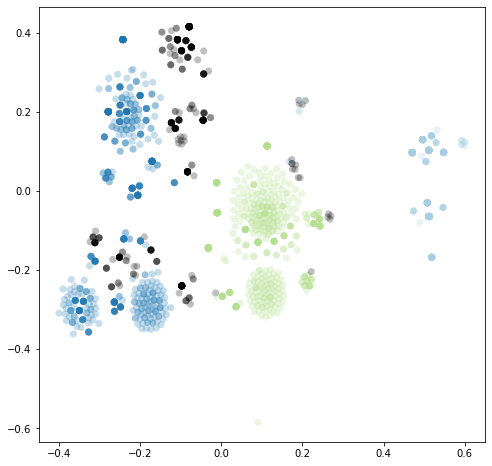

In [147]:
color_palette = sns.color_palette('Paired', len(hdb_labels))
cluster_colors = [color_palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in hdb_labels]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(*X_norm.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

### Analysis

In [148]:
print(f'Number of labels: {max(hdb_labels) + 1}')
print(f'Outlier: {list(hdb_labels).count(-1) / len(hdb_labels) * 100:.02f}%')
for i in range(0, max(hdb_labels) + 1):
    print(f'Cluster {i}: {len(hdb_labels[hdb_labels==i]) / len(hdb_labels) * 100:.02f}%')

Number of labels: 3
Outlier: 20.97%
Cluster 0: 15.77%
Cluster 1: 35.00%
Cluster 2: 28.27%


In [149]:
sample = df_flow[(hdb_labels==1)]
sample

,packets_sent,bytes_sent,packets_recv,bytes_recv,packets_sent_to_target,bytes_sent_to_target,avg_packets_sent_size,packets_recv_from_target,bytes_recv_from_target,avg_packets_recv_size,packets_sent_to_port,bytes_sent_to_port,packets_recv_from_port,bytes_recv_from_port,distinct_to,distinct_ports,n_entries_to_target,distinct_ports_to_target,n_entries_to_port,STos,packets_between_src_dst,bytes_between_src_dst,Src_IP,Dst_IP,Src_Port,Dst_Port,Protocol,Duration,First_Seen,Last_Seen,botnets,exploits,tor,phishing,ransomware,malware,spam,cryptomining,scanner
5,1,126,1,126,1,126,126.0,1,331,331.0,1,126,1,331,1,1,1,1,1,0,1,126,140.123.102.177,31.171.154.67,11639.0,51119.0,17.0,0.0,2023-03-31 17:05:10,2023-03-31 17:05:10,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,1,126,1,126,1,126,126.0,1,300,300.0,1,126,1,300,1,1,1,1,1,0,1,126,140.123.102.177,221.142.135.128,11639.0,51413.0,17.0,0.0,2023-03-31 17:36:22,2023-03-31 17:36:22,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,1,126,1,126,1,126,126.0,1,331,331.0,1,126,1,331,1,1,1,1,1,0,1,126,140.123.102.177,31.171.154.67,11639.0,51119.0,17.0,0.0,2023-03-31 18:05:28,2023-03-31 18:05:28,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11,1,126,1,126,1,126,126.0,0,0,0.0,1,126,0,0,1,1,1,1,1,0,1,126,140.123.102.177,31.171.154.67,11639.0,51119.0,17.0,0.0,2023-03-31 18:35:33,2023-03-31 18:35:33,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13,1,126,1,126,1,126,126.0,1,331,331.0,1,126,1,331,1,1,1,1,1,0,1,126,140.123.102.177,31.171.154.67,11639.0,51119.0,17.0,0.0,2023-03-31 19:05:40,2023-03-31 19:05:40,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1,46,1,46,1,46,46.0,0,0,0.0,1,46,0,0,1,1,1,1,1,40,1,46,170.130.187.22,140.123.105.148,50582.0,443.0,6.0,0.0,2023-06-09 09:57:20,2023-06-09 09:57:20,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
98,1,46,1,46,1,46,46.0,0,0,0.0,1,46,0,0,1,1,1,1,1,40,1,46,104.206.128.14,140.123.101.244,56131.0,443.0,6.0,0.0,2023-06-09 10:32:16,2023-06-09 10:32:16,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
99,2,92,1,46,1,46,46.0,0,0,0.0,2,92,0,0,2,1,1,1,1,40,1,46,170.130.187.22,140.123.255.93,55307.0,443.0,6.0,0.0,2023-06-09 12:13:31,2023-06-09 12:13:31,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
100,2,92,1,46,1,46,46.0,0,0,0.0,2,92,0,0,2,1,1,1,1,40,1,46,170.130.187.22,140.123.102.221,55307.0,443.0,6.0,0.0,2023-06-09 12:13:32,2023-06-09 12:13:32,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
